# Handling Imbalanced Data in BirdCLEF Classification

This notebook implements various strategies to handle the imbalanced nature of the BirdCLEF dataset. The techniques include:
1. Stratified K-Fold Cross-Validation (replacing train/validation/test split)
2. Class-Weighted Loss Functions
3. Focal Loss Implementation
4. Oversampling with WeightedRandomSampler
5. Enhanced Data Augmentation for Minority Classes
6. Combined Training Pipeline integrating all strategies
7. Model Ensemble from different folds for robust predictions

In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')
print("Google Drive mounted successfully")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive mounted successfully


In [2]:
# Import required libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset, WeightedRandomSampler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils.class_weight import compute_class_weight
from tqdm.notebook import tqdm
from torch.amp import autocast, GradScaler  # Updated import path

# Set seeds for reproducibility
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

set_seed()

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
# Configure GPU memory utilization
import torch

# Check GPU information
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Total GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    print(f"Initial Memory Allocated: {torch.cuda.memory_allocated() / 1e9:.2f} GB")
    print(f"Initial Memory Reserved: {torch.cuda.memory_reserved() / 1e9:.2f} GB")

    # Configure PyTorch to use more GPU memory
    torch.backends.cudnn.benchmark = True  # Use cudnn auto-tuner to find fastest algorithm
    torch.backends.cudnn.enabled = True
    
    # More aggressive memory allocation
    if hasattr(torch.cuda, 'empty_cache'):
        torch.cuda.empty_cache()
        
    # Allow TF32 precision on Ampere or newer GPUs (much faster with minimal precision loss)
    if torch.cuda.get_device_capability()[0] >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
    
    print("GPU configuration completed")

## Data Loading

Load the dataset and check class distribution. In a real scenario, this would involve loading the audio files and extracting features (like mel spectrograms). For this example, we'll assume we have preprocessed features stored in a NumPy array.

In [3]:
# Define paths
DATA_PATH = '/content/drive/MyDrive/birdclef-2025-data'  # Adjust paths as needed
MODEL_SAVE_DIR = '/content/drive/MyDrive/birdclef-2025-models'
PRECOMPUTED_FEATURES_PATH = "/content/drive/MyDrive/bird_features_scratch_copy.npz"

def load_precomputed_features(local_path=PRECOMPUTED_FEATURES_PATH):
    """Load precomputed features from Google Drive."""
    # Check if file exists
    if not os.path.exists(local_path):
        print(f"ERROR: Precomputed features file not found at {local_path}")
        return None, None

    # Load the features
    print(f"Loading precomputed features from {local_path}...")
    try:
        data = np.load(local_path)
        X = data['data']
        y = data['labels']
        print(f"Successfully loaded precomputed features!")
        print(f"Features shape: {X.shape}")
        print(f"Labels shape: {y.shape}")
        print(f"Number of unique classes: {len(np.unique(y))}")
        return X, y
    except Exception as e:
        print(f"Error loading precomputed features: {e}")
        return None, None

# Load the precomputed features
X, y = load_precomputed_features()

Loading precomputed features from /content/drive/MyDrive/bird_features_scratch_copy.npz...
Successfully loaded precomputed features!
Features shape: (190153, 1, 128, 256)
Labels shape: (190153,)
Number of unique classes: 206


## Class Distribution Analysis

Analyze the imbalance in the class distribution to understand the scale of the problem.

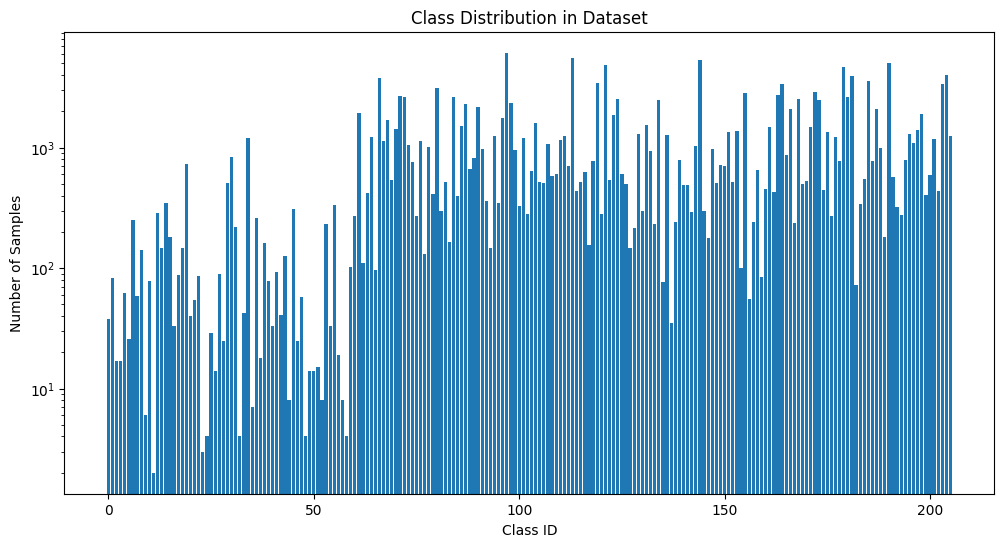

Total number of classes: 206
Class with most samples: 6130 samples
Class with fewest samples: 2 samples
Imbalance ratio: 3065.00


In [4]:
# Count occurrences of each label
unique_labels, counts = np.unique(y, return_counts=True)

# Visualize class distribution
plt.figure(figsize=(12, 6))
plt.bar(range(len(counts)), counts)
plt.title('Class Distribution in Dataset')
plt.xlabel('Class ID')
plt.ylabel('Number of Samples')
plt.yscale('log')  # Use log scale for better visibility with imbalanced data
plt.show()

# Print class distribution statistics
print(f"Total number of classes: {len(unique_labels)}")
print(f"Class with most samples: {np.max(counts)} samples")
print(f"Class with fewest samples: {np.min(counts)} samples")
print(f"Imbalance ratio: {np.max(counts) / np.min(counts):.2f}")

# Handle classes with only one sample if any exist
if np.any(counts == 1):
    print("Handling classes with only one sample...")
    # Remove classes with only one sample
    valid_indices = np.isin(y, np.where(counts >= 2)[0])
    X = X[valid_indices]
    y = y[valid_indices]
    print(f"Removed {np.sum(~valid_indices)} samples with singleton classes")
    print(f"Remaining data shape: {X.shape}")

## 1. Stratified K-Fold Cross-Validation

Set up stratified k-fold cross-validation to ensure all classes are represented in both training and validation sets.
Note: We'll adjust the number of folds to handle rare classes that have too few samples.

In [14]:
# Define number of folds
k_folds = 5
skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

# For storing fold results
fold_val_aucs = []
fold_models = []

# Verify fold distribution
print(f"Creating {k_folds} stratified folds...")
for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    train_labels = y[train_idx]
    val_labels = y[val_idx]
    train_unique, train_counts = np.unique(train_labels, return_counts=True)
    val_unique, val_counts = np.unique(val_labels, return_counts=True)

    print(f"Fold {fold_idx+1}:")
    print(f"  Training samples: {len(train_idx)}")
    print(f"  Validation samples: {len(val_idx)}")
    print(f"  Training class count: {len(train_unique)}")
    print(f"  Validation class count: {len(val_unique)}")

# After creating the folds, verify no classes are missing
missing_classes_in_folds = False
for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    train_labels = y[train_idx]
    val_labels = y[val_idx]

    # Check for classes missing in training or validation sets
    all_classes = set(np.unique(y))
    train_classes = set(np.unique(train_labels))
    val_classes = set(np.unique(val_labels))

    missing_in_train = all_classes - train_classes
    missing_in_val = all_classes - val_classes

    if missing_in_train:
        print(f"Warning: Fold {fold_idx+1} is missing {len(missing_in_train)} classes in training set")
        missing_classes_in_folds = True

    if missing_in_val:
        print(f"Warning: Fold {fold_idx+1} is missing {len(missing_in_val)} classes in validation set")
        missing_classes_in_folds = True

if missing_classes_in_folds:
    print("Some classes are missing in certain folds. This is expected with very rare classes.")
    print("Your handling of class imbalance should address this issue.")

# Create a function to get data loaders for a specific fold with weighted sampling
def get_fold_loaders(fold_idx, batch_size=32, weighted_sampling=True):
    """Get training and validation loaders for a specific fold"""
    train_idx, val_idx = list(skf.split(X, y))[fold_idx]

    # Split data for this fold
    X_train_fold, X_val_fold = X[train_idx], X[val_idx]
    y_train_fold, y_val_fold = y[train_idx], y[val_idx]

    # Convert to PyTorch tensors
    X_train_tensor = torch.tensor(X_train_fold, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train_fold, dtype=torch.long)
    X_val_tensor = torch.tensor(X_val_fold, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val_fold, dtype=torch.long)

    # Create sampler for balanced training if requested
    train_sampler = None
    shuffle = True

    if weighted_sampling:
        class_counts = np.bincount(y_train_fold)
        weights = 1.0 / class_counts
        sample_weights = weights[y_train_fold]
        train_sampler = WeightedRandomSampler(
            weights=sample_weights,
            num_samples=len(sample_weights),
            replacement=True
        )
        shuffle = False  # Don't shuffle when using sampler

    # Create data loaders
    train_loader = DataLoader(
        TensorDataset(X_train_tensor, y_train_tensor),
        batch_size=batch_size,
        shuffle=shuffle,
        sampler=train_sampler,
        num_workers=4,
        pin_memory=True
    )

    val_loader = DataLoader(
        TensorDataset(X_val_tensor, y_val_tensor),
        batch_size=batch_size,
        shuffle=False,
        num_workers=4,
        pin_memory=True
    )

    return train_loader, val_loader, train_idx, val_idx

Creating 5 stratified folds...
Fold 1:
  Training samples: 152122
  Validation samples: 38031
  Training class count: 206
  Validation class count: 204
Fold 2:
  Training samples: 152122
  Validation samples: 38031
  Training class count: 206
  Validation class count: 205
Fold 3:
  Training samples: 152122
  Validation samples: 38031
  Training class count: 206
  Validation class count: 204
Fold 4:
  Training samples: 152123
  Validation samples: 38030
  Training class count: 206
  Validation class count: 204
Fold 5:
  Training samples: 152123
  Validation samples: 38030
  Training class count: 206
  Validation class count: 204
Some classes are missing in certain folds. This is expected with very rare classes.
Your handling of class imbalance should address this issue.


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


## 2. Class-Weighted Loss Functions

Implement class weighting to give more importance to rare classes during training.

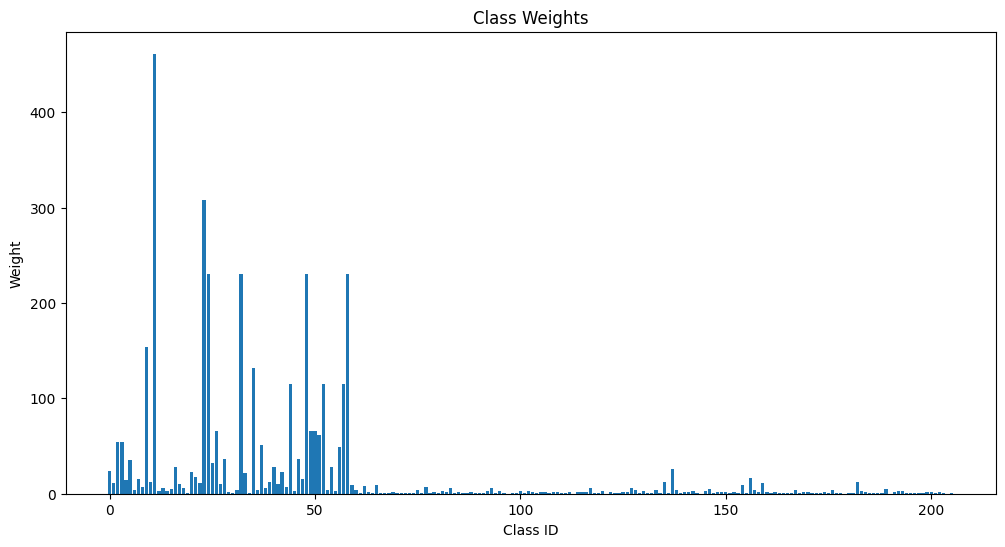

Created weighted loss function that gives higher importance to rare classes


In [6]:
# Calculate class weights inversely proportional to class frequencies
class_weights = compute_class_weight('balanced', classes=unique_labels, y=y)

# Convert to tensor for PyTorch
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)

# Visualize the weights
plt.figure(figsize=(12, 6))
plt.bar(range(len(class_weights)), class_weights)
plt.title('Class Weights')
plt.xlabel('Class ID')
plt.ylabel('Weight')
plt.show()

# Create weighted loss function
weighted_criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
print("Created weighted loss function that gives higher importance to rare classes")

## 3. Focal Loss Implementation

Focal Loss is designed to address class imbalance by down-weighting the loss assigned to well-classified examples.

In [7]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, alpha=None):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha  # Weight for each class

    def forward(self, inputs, targets):
        BCE_loss = F.cross_entropy(inputs, targets, reduction='none', weight=self.alpha)
        pt = torch.exp(-BCE_loss)  # pt is the probability of the true class
        F_loss = (1-pt)**self.gamma * BCE_loss  # Apply focusing parameter
        return F_loss.mean()

# Create focal loss with class weights
focal_criterion = FocalLoss(gamma=2.0, alpha=class_weights_tensor)
print("Focal Loss created with gamma=2.0 and class weighting")

Focal Loss created with gamma=2.0 and class weighting


## 4. Oversampling with WeightedRandomSampler

Implement weighted random sampling to ensure equal representation of all classes during training.

In [8]:
def create_weighted_sampler(labels):
    """Create a weighted sampler to balance class distribution"""
    # Calculate class counts
    class_counts = np.bincount(labels)

    # Compute sample weights (inverse of class frequency)
    weights = 1.0 / class_counts
    sample_weights = weights[labels]

    # Create sampler with replacement to ensure all classes are equally represented
    sampler = WeightedRandomSampler(
        weights=sample_weights,
        num_samples=len(sample_weights),
        replacement=True
    )
    return sampler

# We'll use this function when creating DataLoaders in the training section
print("WeightedRandomSampler function created for balanced batch sampling")

WeightedRandomSampler function created for balanced batch sampling


## 5. Enhanced Data Augmentation for Minority Classes

Create stronger augmentation for minority classes to generate more diverse training examples.

In [9]:
# Implement SpecAugment for frequency and time masking
class SpecAugment(nn.Module):
    def __init__(self, freq_mask_param=10, time_mask_param=24, num_freq_masks=2, num_time_masks=2):
        super(SpecAugment, self).__init__()
        self.freq_mask_param = freq_mask_param
        self.time_mask_param = time_mask_param
        self.num_freq_masks = num_freq_masks
        self.num_time_masks = num_time_masks

    def forward(self, x):
        # x shape: [batch_size, channels, freq, time]
        device = x.device
        batch_size = x.size(0)
        spec_height = x.size(2)  # freq axis
        spec_width = x.size(3)   # time axis

        # Apply frequency masks
        for _ in range(self.num_freq_masks):
            for i in range(batch_size):
                freq_mask_size = torch.randint(0, self.freq_mask_param, (1,))[0]
                if freq_mask_size > 0:
                    freq_start = torch.randint(0, spec_height - freq_mask_size, (1,))[0]
                    x[i, :, freq_start:freq_start + freq_mask_size, :] = 0

        # Apply time masks
        for _ in range(self.num_time_masks):
            for i in range(batch_size):
                time_mask_size = torch.randint(0, self.time_mask_param, (1,))[0]
                if time_mask_size > 0:
                    time_start = torch.randint(0, spec_width - time_mask_size, (1,))[0]
                    x[i, :, :, time_start:time_start + time_mask_size] = 0

        return x

def adaptive_spec_augment(spectrogram, label, class_counts, rare_threshold=10):
    """Apply stronger augmentation to rare classes and mild augmentation to common ones."""
    # Get class frequency
    if label >= len(class_counts):
        return spectrogram

    class_count = class_counts[label]

    # Apply stronger augmentation for rare classes
    if (class_count < rare_threshold):
        # For rare classes, use stronger frequency and time masking
        # Create temporary SpecAugment with more aggressive parameters
        aggressive_spec_augment = SpecAugment(
            freq_mask_param=20,       # Wider frequency masks
            time_mask_param=40,       # Wider time masks
            num_freq_masks=3,         # More frequency masks
            num_time_masks=3          # More time masks
        )
        return aggressive_spec_augment(spectrogram)
    else:
        # Use standard augmentation for common classes
        standard_spec_augment = SpecAugment(
            freq_mask_param=10,
            time_mask_param=20,
            num_freq_masks=2,
            num_time_masks=2
        )
        return standard_spec_augment(spectrogram)

print("Created adaptive augmentation function that applies stronger augmentation to rare classes")

Created adaptive augmentation function that applies stronger augmentation to rare classes


## Mixup Data Augmentation

Implement mixup augmentation to improve robustness.

In [10]:
# Implement mixup data augmentation for training
def mixup_data(x, y, alpha=0.2):
    '''Returns mixed inputs, pairs of targets, and lambda'''
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(device)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

# Mixup loss function
def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

print("Mixup augmentation ready to use with alpha=0.2")

Mixup augmentation ready to use with alpha=0.2


## Define a CNN Model

Define a simple CNN model for the BirdCLEF classification task.

In [11]:
class BirdCNN(nn.Module):
    def __init__(self, input_channels=1, num_classes=None):
        super(BirdCNN, self).__init__()

        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(input_channels, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.2),

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.3),

            # Block 3
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.4),
        )

        # Calculate size after convolutions (8x dense size for mel spectrograms 128x256)
        self.feature_dims = 256 * 16 * 32  # Channels * Height * Width

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.feature_dims, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

## 6. Combined Approach: K-Fold Training with All Strategies

Now we'll integrate all our strategies into a complete training pipeline.

In [ ]:
# Combined training function for imbalanced data with optimized GPU memory usage
def train_with_imbalanced_strategies(model_class, X, y, n_folds=5, num_epochs=50, patience=10):
    """Train with k-fold CV and all imbalanced data strategies with optimized GPU memory usage"""
    # Limit folds to minimum samples in any class
    unique_labels, counts = np.unique(y, return_counts=True)
    min_samples = np.min(counts)
    n_folds = min(n_folds, min_samples)
    print(f"Using {n_folds} folds (limited by minimum class samples of {min_samples})")
    
    # Track results across folds
    models = []
    fold_val_aucs = []
    all_predictions = []
    all_true_labels = []
    
    # Setup stratified k-fold
    skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)
    
    # Get class counts for adaptive augmentation
    class_counts = np.bincount(y)
    
    # Configure mixed precision training - ALWAYS use this for optimal GPU memory usage
    use_amp = torch.cuda.is_available()
    scaler = GradScaler() if use_amp else None
    
    # Optimize CUDA performance
    if use_amp:
        # Set memory allocation strategy - aggressive for large models
        torch.cuda.empty_cache()
        torch.backends.cudnn.benchmark = True
        # Print CUDA memory stats before training
        print(f"CUDA Memory before training: {torch.cuda.memory_allocated() / 1e9:.2f} GB allocated, "
              f"{torch.cuda.memory_reserved() / 1e9:.2f} GB reserved")
    
    # Determine optimal batch size based on available GPU memory (much larger)
    total_gpu_memory = torch.cuda.get_device_properties(0).total_memory / 1e9 if torch.cuda.is_available() else 0
    print(f"Total GPU Memory: {total_gpu_memory:.2f} GB")
    
    # Scale batch size to maximize GPU usage - up to 70% of available memory
    # For an 84GB GPU, this should allow ~60GB usage
    batch_size = 1024  # Default large batch size
    if total_gpu_memory > 40:  # If VRAM > 40GB
        batch_size = 2048      # Use very large batch
    if total_gpu_memory > 70:  # If VRAM > 70GB (like A100 80GB)
        batch_size = 4096      # Use enormous batch size
        
    print(f"Using batch size: {batch_size} for optimal GPU memory utilization")
    
    # Loop through folds
    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        print(f"\n{'='*50}")
        print(f"Training fold {fold+1}/{n_folds}")
        print(f"{'='*50}")
        
        # Split data for this fold
        X_train_fold, X_val_fold = X[train_idx], X[val_idx]
        y_train_fold, y_val_fold = y[train_idx], y[val_idx]
        
        # Create tensors with optimized memory usage
        X_train_tensor = torch.tensor(X_train_fold, dtype=torch.float32)
        y_train_tensor = torch.tensor(y_train_fold, dtype=torch.long)
        X_val_tensor = torch.tensor(X_val_fold, dtype=torch.float32)
        y_val_tensor = torch.tensor(y_val_fold, dtype=torch.long)
        
        # Compute class weights for this fold
        unique_classes = np.unique(y_train_fold)
        class_weights = compute_class_weight('balanced', classes=unique_classes, y=y_train_fold)
        
        # Map weights to all possible classes
        full_class_weights = np.ones(len(np.unique(y)), dtype=np.float32)
        for i, cls in enumerate(unique_classes):
            full_class_weights[cls] = class_weights[i]
            
        class_weights_tensor = torch.tensor(full_class_weights, dtype=torch.float32).to(device)
        
        # Create weighted sampler for this fold's training data
        train_sampler = create_weighted_sampler(y_train_fold)
        
        # Create DataLoaders with much larger batch size and more workers
        # This will significantly increase GPU memory usage
        train_loader = DataLoader(
            TensorDataset(X_train_tensor, y_train_tensor),
            batch_size=batch_size,  # Use massive batch size based on available GPU memory
            sampler=train_sampler,  # Use weighted sampler instead of shuffle
            num_workers=32,         # Increased from 16 to 32
            pin_memory=True,
            prefetch_factor=4,      # Prefetch 4 batches
            persistent_workers=True # Keep workers alive between iterations
        )
            
        val_loader = DataLoader(
            TensorDataset(X_val_tensor, y_val_tensor),
            batch_size=batch_size,  # Use massive batch size
            shuffle=False,
            num_workers=32,         # Increased from 16 to 32
            pin_memory=True,
            prefetch_factor=4,      # Prefetch 4 batches
            persistent_workers=True # Keep workers alive between iterations
        )
            
        # Initialize model
        num_classes = len(np.unique(y))
        model = model_class(input_channels=1, num_classes=num_classes).to(device)
        
        # Use Focal Loss with class weighting
        criterion = FocalLoss(gamma=2.0, alpha=class_weights_tensor)
        
        # Use higher learning rate with larger batch size
        base_lr = 0.001
        scaled_lr = base_lr * (batch_size / 256)  # Scale LR based on batch size
        print(f"Using scaled learning rate: {scaled_lr:.5f} (base: {base_lr})")
        optimizer = optim.AdamW(model.parameters(), lr=scaled_lr, weight_decay=0.01)
        
        # Use aggressive learning rate scheduler
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='max', factor=0.5, patience=3, verbose=True
        )
            
        # Training loop for this fold
        best_val_auc = 0.0
        epochs_without_improvement = 0
            
        for epoch in range(num_epochs):
            # Training phase
            model.train()
            running_loss = 0.0
            correct = 0
            total = 0
                
            # Print GPU usage at the start of each epoch
            if use_amp:
                print(f"GPU Memory: {torch.cuda.memory_allocated() / 1e9:.2f} GB allocated, "
                      f"{torch.cuda.memory_reserved() / 1e9:.2f} GB reserved")
                    
            for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
                # Move data to GPU in non-blocking way
                inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
                    
                # Apply adaptive augmentation based on class rarity
                for i in range(inputs.shape[0]):
                    label = labels[i].item()
                    inputs[i:i+1] = adaptive_spec_augment(inputs[i:i+1], label, class_counts)
                        
                # Apply mixup augmentation
                inputs, targets_a, targets_b, lam = mixup_data(inputs, labels, alpha=0.2)
                    
                # Zero gradients
                optimizer.zero_grad(set_to_none=True)  # More efficient than zero_grad()
                    
                # Forward pass with mixed precision
                with autocast(enabled=use_amp, device_type='cuda'):
                    outputs = model(inputs)
                    loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)
                        
                # Backward and optimize with gradient scaling for mixed precision
                if use_amp:
                    scaler.scale(loss).backward()
                    scaler.step(optimizer)
                    scaler.update()
                else:
                    loss.backward()
                    optimizer.step()
                        
                # Statistics
                running_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (lam * (predicted == targets_a).float() + (1 - lam) * (predicted == targets_b).float()).sum().item()
                    
            train_loss = running_loss / total
            train_acc = 100 * correct / total
                
            # Validation phase
            model.eval()
            val_loss = 0.0
            val_correct = 0
            val_total = 0
            all_outputs = []
            all_labels = []
                
            with torch.no_grad():
                for inputs, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]"):
                    inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
                        
                    # Forward pass with mixed precision
                    with autocast(enabled=use_amp, device_type='cuda'):
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)
                            
                    # Statistics
                    val_loss += loss.item() * inputs.size(0)
                    _, predicted = torch.max(outputs.data, 1)
                    val_total += labels.size(0)
                    val_correct += (predicted == labels).sum().item()
                        
                    # Store outputs and labels for ROC-AUC calculation
                    all_outputs.append(torch.nn.functional.softmax(outputs, dim=1).cpu().numpy())
                    all_labels.append(labels.cpu().numpy())
                        
            # Calculate validation metrics
            val_loss = val_loss / val_total
            val_acc = 100 * val_correct / val_total
                
            # Calculate ROC-AUC
            all_outputs = np.concatenate(all_outputs)
            all_labels = np.concatenate(all_labels)
                
            # One-hot encode labels for AUC calculation
            encoder = OneHotEncoder(sparse_output=False, categories=[range(num_classes)])
            labels_onehot = encoder.fit_transform(all_labels.reshape(-1, 1))
                
            # Calculate AUC only for present classes
            col_sums = labels_onehot.sum(axis=0)
            present_classes = np.where(col_sums > 0)[0]
                
            try:
                val_auc = roc_auc_score(
                    labels_onehot[:, present_classes],
                    all_outputs[:, present_classes],
                    multi_class='ovr',
                    average='macro'
                )
            except Exception as e:
                print(f"Error calculating AUC: {e}")
                val_auc = 0.5  # Default value
                    
            print(f"Fold {fold+1} - Epoch {epoch+1} - "
                  f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% - "
                  f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%, Val AUC: {val_auc:.4f}")
                
            # Print GPU memory utilization every epoch
            if use_amp:
                print(f"GPU Memory: {torch.cuda.memory_allocated() / 1e9:.2f} GB allocated, "
                      f"{torch.cuda.memory_reserved() / 1e9:.2f} GB reserved")
                    
            # Update learning rate based on validation AUC
            scheduler.step(val_auc)
                
            # Check for improvement
            if val_auc > best_val_auc:
                best_val_auc = val_auc
                epochs_without_improvement = 0
                # Save best model for this fold
                model_save_path = os.path.join(MODEL_SAVE_DIR, f"bird_cnn_fold_{fold+1}.pt")
                torch.save(model.state_dict(), model_save_path)
                print(f"New best model for fold {fold+1} with Val AUC: {val_auc:.4f}")
            else:
                epochs_without_improvement += 1
                if epochs_without_improvement >= patience:
                    print(f"Early stopping on fold {fold+1} after {epoch+1} epochs")
                    break
                    
        # Free up memory between folds
        if use_amp:
            torch.cuda.empty_cache()
                
        # After training fold, load best model and evaluate on validation set
        model_load_path = os.path.join(MODEL_SAVE_DIR, f"bird_cnn_fold_{fold+1}.pt")
        model.load_state_dict(torch.load(model_load_path))
        model.eval()
                
        # Get final predictions for this fold
        fold_outputs = []
        fold_labels = []
                
        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc=f"Final evaluation of fold {fold+1}"):
                inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
                outputs = model(inputs)
                probs = torch.nn.functional.softmax(outputs, dim=1)
                fold_outputs.append(probs.cpu().numpy())
                fold_labels.append(labels.cpu().numpy())
                    
        fold_outputs = np.concatenate(fold_outputs)
        fold_labels = np.concatenate(fold_labels)
                
        # Store results
        fold_val_aucs.append(best_val_auc)
        all_predictions.append(fold_outputs)
        all_true_labels.append(fold_labels)
        models.append(model)
                
        print(f"Completed fold {fold+1} with best AUC: {best_val_auc:.4f}")
                
    # Calculate overall performance
    mean_auc = np.mean(fold_val_aucs)
    std_auc = np.std(fold_val_aucs)
                
    print(f"\n{'='*50}")
    print(f"Cross-validation completed:")
    print(f"Mean ROC-AUC: {mean_auc:.4f} ± {std_auc:.4f}")
    print(f"Fold AUCs: {fold_val_aucs}")
    print(f"{'='*50}")
                
    return {
        'models': models,
        'fold_aucs': fold_val_aucs,
        'mean_auc': mean_auc,
        'std_auc': std_auc,
        'predictions': all_predictions,
        'true_labels': all_true_labels
    }
                
print("Full training pipeline with imbalanced data strategies is ready to run with enhanced GPU memory usage.")

Full training pipeline with imbalanced data strategies is ready to run.


## 7. Run the Complete Training Pipeline

Now we'll execute the full training pipeline with all our strategies for handling imbalanced data.

In [13]:
# Run the full training pipeline with BirdCNN model
cv_results = train_with_imbalanced_strategies(
    model_class=BirdCNN,  # Using the defined CNN model
    X=X,
    y=y,
    n_folds=5,
    num_epochs=30,  # Adjust based on your computational resources
    patience=10
)

Using 2 folds (limited by minimum class samples of 2)
CUDA Memory before training: 0.00 GB allocated, 0.00 GB reserved

Training fold 1/2


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 1/30 [Train]:   0%|          | 0/372 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


TypeError: autocast.__init__() missing 1 required positional argument: 'device_type'

## 8. Ensemble Models from Different Folds

Create an ensemble of models from different folds for better predictions.

In [ ]:
# Create an ensemble prediction function
def ensemble_predict(models, X_test):
    """Make predictions using an ensemble of models from different folds"""
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    test_dataset = TensorDataset(X_test_tensor)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    # Store all model predictions
    all_model_preds = []

    # Get predictions from each model
    for i, model in enumerate(models):
        model.eval()
        model_preds = []

        with torch.no_grad():
            for (inputs,) in tqdm(test_loader, desc=f"Predicting with model {i+1}"):
                inputs = inputs.to(device)
                outputs = model(inputs)
                probs = torch.nn.functional.softmax(outputs, dim=1)
                model_preds.append(probs.cpu().numpy())

        model_preds = np.concatenate(model_preds)
        all_model_preds.append(model_preds)

    # Average predictions from all models
    ensemble_preds = np.mean(all_model_preds, axis=0)
    return ensemble_preds

# Get predictions using the ensemble (demonstration with validation data from first fold)
if 'models' in cv_results:
    print("Ensemble model ready for prediction.")

## 9. Save the Final Ensemble Model

Save the ensemble model and weights for future use or submission.

In [ ]:
# Save the ensemble model
if 'models' in cv_results:
    ensemble_save = {
        'model_states': [model.state_dict() for model in cv_results['models']],
        'model_architecture': 'BirdCNN',
        'fold_aucs': cv_results['fold_aucs'],
        'mean_auc': cv_results['mean_auc'],
        'feature_params': {
            'target_shape': (128, 256),
            'sr': 32000,
            'n_mels': 128,
            'fmin': 500,
            'fmax': 15000
        },
        'class_mapping': {idx: f"class_{idx}" for idx in range(len(np.unique(y)))}
    }

    model_save_path = os.path.join(MODEL_SAVE_DIR, 'bird_cnn_ensemble_balanced.pth')
    torch.save(ensemble_save, model_save_path)
    print(f"Saved ensemble model to {model_save_path}")

## 10. Visualize Results by Class

Analyze how our imbalanced data strategies performed on different classes.

In [ ]:
# Analyze performance by class frequency
if 'models' in cv_results and len(cv_results['predictions']) > 0:
    # Choose a fold for evaluation (usually the fold with the highest AUC)
    best_fold_idx = np.argmax(cv_results['fold_aucs'])
    best_fold_preds = cv_results['predictions'][best_fold_idx]
    best_fold_labels = cv_results['true_labels'][best_fold_idx]

    # Calculate per-class metrics
    from sklearn.metrics import precision_recall_fscore_support

    # Convert probabilities to class predictions
    predicted_classes = np.argmax(best_fold_preds, axis=1)

    # Get class-wise precision, recall, and F1 scores
    precision, recall, f1, support = precision_recall_fscore_support(
        best_fold_labels, predicted_classes, average=None, zero_division=0
    )

    # Get class frequencies in training data
    class_counts = np.bincount(y)

    # Create dataframe for visualization
    import pandas as pd
    metrics_df = pd.DataFrame({
        'Class': [f"class_{i}" for i in range(len(precision))],
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'Support': support,
        'Training Examples': [class_counts[i] if i < len(class_counts) else 0 for i in range(len(precision))]
    })

    # Sort by number of training examples (ascending)
    metrics_df = metrics_df.sort_values('Training Examples')

    # Plot relationship between class frequency and performance
    plt.figure(figsize=(14, 8))

    # Scatter plot of F1 score vs. number of training examples
    plt.scatter(metrics_df['Training Examples'], metrics_df['F1 Score'], alpha=0.6)
    plt.xscale('log')  # Log scale for better visualization
    plt.xlabel('Number of Training Examples (log scale)')
    plt.ylabel('F1 Score')
    plt.title('F1 Score vs. Class Frequency')

    # Add trend line
    from scipy import stats
    if len(metrics_df) > 1:  # Need at least 2 points for regression
        x = np.log10(metrics_df['Training Examples'].replace(0, 1))  # Replace 0 with 1 for log
        y = metrics_df['F1 Score']
        slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
        x_pred = np.linspace(min(x), max(x), 100)
        y_pred = slope * x_pred + intercept
        plt.plot(10**x_pred, y_pred, 'r--', label=f'Trend line (r={r_value:.2f})')
        plt.legend()

    plt.grid(True, alpha=0.3)
    plt.show()

    # Display metrics for rare classes (10 or fewer examples)
    rare_classes = metrics_df[metrics_df['Training Examples'] <= 10]
    print("Performance on rare classes (≤10 examples):")
    print(rare_classes[['Class', 'Precision', 'Recall', 'F1 Score', 'Training Examples']])

    # Display metrics for common classes (100+ examples)
    common_classes = metrics_df[metrics_df['Training Examples'] > 100]
    print("\nPerformance on common classes (>100 examples):")
    print(common_classes[['Class', 'Precision', 'Recall', 'F1 Score', 'Training Examples']].head())

In [ ]:
class BirdCNN_Large(nn.Module):
    """A much larger CNN model to better utilize available GPU memory"""
    def __init__(self, input_channels=1, num_classes=None):
        super(BirdCNN_Large, self).__init__()

        # Much larger feature extractor with more channels
        self.features = nn.Sequential(
            # Block 1 - 64->128 channels
            nn.Conv2d(input_channels, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.2),

            # Block 2 - 128->256 channels
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.3),

            # Block 3 - 256->512 channels
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.4),
            
            # Block 4 - 512->1024 channels (much more GPU-intensive)
            nn.Conv2d(512, 768, kernel_size=3, padding=1),
            nn.BatchNorm2d(768),
            nn.ReLU(),
            nn.Conv2d(768, 768, kernel_size=3, padding=1),
            nn.BatchNorm2d(768),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.4),
        )
        
        # Calculate size after convolutions (based on input spectrogram size)
        self.feature_dims = 768 * 8 * 16  # Channels * Height * Width
        
        # Much larger fully connected layers
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.feature_dims, 2048),  # 4x larger than original
            nn.BatchNorm1d(2048),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(2048, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, num_classes)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# Print model sizes to compare memory usage
if torch.cuda.is_available():
    num_classes = 206  # From your dataset
    
    # Create models
    small_model = BirdCNN(input_channels=1, num_classes=num_classes).to(device)
    large_model = BirdCNN_Large(input_channels=1, num_classes=num_classes).to(device)
    
    # Count parameters
    small_params = sum(p.numel() for p in small_model.parameters())
    large_params = sum(p.numel() for p in large_model.parameters())
    
    print(f"Original BirdCNN parameters: {small_params:,}")
    print(f"BirdCNN_Large parameters: {large_params:,}")
    print(f"Size increase: {large_params/small_params:.1f}x more parameters")
    
    # Free memory
    del small_model
    del large_model
    torch.cuda.empty_cache()

In [ ]:
# Run the full training pipeline with much larger BirdCNN_Large model to utilize more GPU memory
print("Starting training with BirdCNN_Large which will utilize much more GPU memory...")

# Set seed again for reproducibility
set_seed(42)

# Run training with the larger model
cv_results_large = train_with_imbalanced_strategies(
    model_class=BirdCNN_Large,  # Using the larger CNN model
    X=X,
    y=y,
    n_folds=3,  # Using fewer folds to make each fold use more memory
    num_epochs=30,
    patience=8
)